# =================================================================
# PROJET : Pipeline de préparation de données - Détection de Fraude
# ÉTUDIANT : Daniel Yakana; Kylian Kouda; Eric Feuzeu; Sorel Fotsing
# =================================================================

# Importation des bibliotheques

In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, average_precision_score

###  Description des Variables du Dataset

Le jeu de données contient des transactions effectuées par carte bancaire sur une période de deux jours. Voici la description des 31 variables présentes :

| Variable | Description | Nature / Remarque |
| :--- | :--- | :--- |
| **Time** | Nombre de secondes écoulées entre la transaction actuelle et la toute première transaction du jeu de données. | Numérique (Temporel) |
| **V1 à V28** | Composantes principales obtenues grâce à une Analyse en Composantes Principales (PCA). | Numérique (Anonymisé) |
| **Amount** | Montant de la transaction. | Numérique (Monétaire) |
| **Class** | Variable cible (Target). Indique si la transaction est une fraude (1) ou non (0). | Binaire (0 ou 1) |

####  Détails Importants sur les Variables :

* **Variables V1-V28 (PCA)** : En raison de problèmes de confidentialité, les caractéristiques d'origine (comme le lieu ou le type de commerce) ne sont pas fournies. Elles ont été transformées par PCA pour protéger l'identité des clients tout en conservant la structure des données.
* **Variable 'Time'** : Cette variable permet d'analyser la périodicité des transactions (ex: baisse du volume la nuit).
* **Variable 'Amount'** : Le montant de la transaction. Il est souvent nécessaire de le transformer (ex: Log ou Scaling) car sa distribution est fortement asymétrique (quelques très gros montants vs beaucoup de petits).
* **Déséquilibre de la classe 'Class'** : Le dataset est extrêmement déséquilibré. Les fraudes (Class=1) ne représentent environ que **0,172 %** de l'ensemble des données (492 fraudes sur 284 807 transactions).

-----------------------------------------------------------------
I. Analyse initiale du problème 
-----------------------------------------------------------------
- Contexte : Ce projet vise à traiter le dataset "Credit Card Fraud Detection".
- Identification de la tâche : Il s'agit d'une CLASSIFICATION BINAIRE.
- Objectif : Prédire si une transaction est frauduleuse (Class=1) ou légitime (Class=0).

### Importation du jeu de données

In [23]:
# Chargement des données 
df = pd.read_csv("creditcard.csv")
# Aperçu des données
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [25]:
# confirmons que la colonne "Class" est bien binaire
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

La variable "Class" etant bel et bien binaire, nous pouvons conclure la qu'il s'agira ici d'un probleme de classification binaire.

# II. Exploration et diagnotic des donnees

In [26]:
# taille du dataset
print(f"Taille du dataset : {df.shape}")

Taille du dataset : (284807, 31)


In [27]:
# Statistiques descriptives
print(df.describe())

                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.23709

In [49]:
# verification des valeurs manquantes
print(df.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


le jeu de donnees ne contient aucune valeur manquante

## Gestion et analyses des doublons

In [55]:
# verifions s'il ya des doublons
duplicates = df[df.duplicated(keep=False)] # On garde toutes les occurrences pour l'analyse
total_duplicates = df.duplicated().sum()

In [56]:
# 2. Analyse de la distribution des classes au sein des doublons
duplicates_class_counts = duplicates['Class'].value_counts()
fraud_in_duplicates = duplicates_class_counts.get(1, 0)
legit_in_duplicates = duplicates_class_counts.get(0, 0)

print(f"Nombre total de lignes dupliquées : {total_duplicates}")
print(f"Nombre de fraudes dans les doublons : {fraud_in_duplicates}")
print(f"Nombre de transactions légitimes dans les doublons : {legit_in_duplicates}")

Nombre total de lignes dupliquées : 1081
Nombre de fraudes dans les doublons : 32
Nombre de transactions légitimes dans les doublons : 1822


In [57]:
# 3. Calcul de la proportion de fraude
# Dans le dataset global, la fraude est de ~0.17%
prop_fraude_doublons = (fraud_in_duplicates / (fraud_in_duplicates + legit_in_duplicates)) * 100

print(f"Proportion de fraude dans les doublons : {prop_fraude_doublons:.2f}%")

Proportion de fraude dans les doublons : 1.73%


C:\Users\elyad\AppData\Local\Temp\ipykernel_32576\2492519745.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Global Dataset', 'Doublons'],


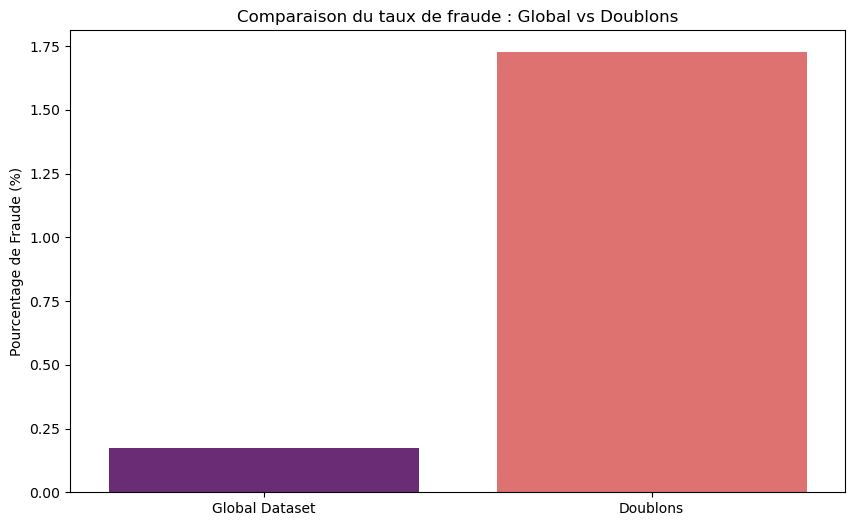

In [58]:
# 4. Visualisation
plt.figure(figsize=(10, 6))
sns.barplot(x=['Global Dataset', 'Doublons'], 
            y=[(df['Class'].sum()/len(df))*100, prop_fraude_doublons], 
            palette='magma')
plt.title('Comparaison du taux de fraude : Global vs Doublons')
plt.ylabel('Pourcentage de Fraude (%)')
plt.show()

- Nous constatons donc qu'il existe 1081 doublons dans notre dataset, mais que le taux de transaction frauduleuses dans celui ci est de 1,73%, ce qui est largement au dessus du taux de transactions frauduleuse dans tout les dataset (0.172).
- Nous avons donc decider de conserver ces doublons car en detection de fraude bancaire, la repetition d'une transaction est souvent le signal d'une attaque automatisee ou d'une tentative de fraude par repetition.
- Les supprimer pourrait biaiser l'entrainement de notre model de ML a la detection d'eventuelles fraudes.

### Analyse des distributions et de l'asymetrie

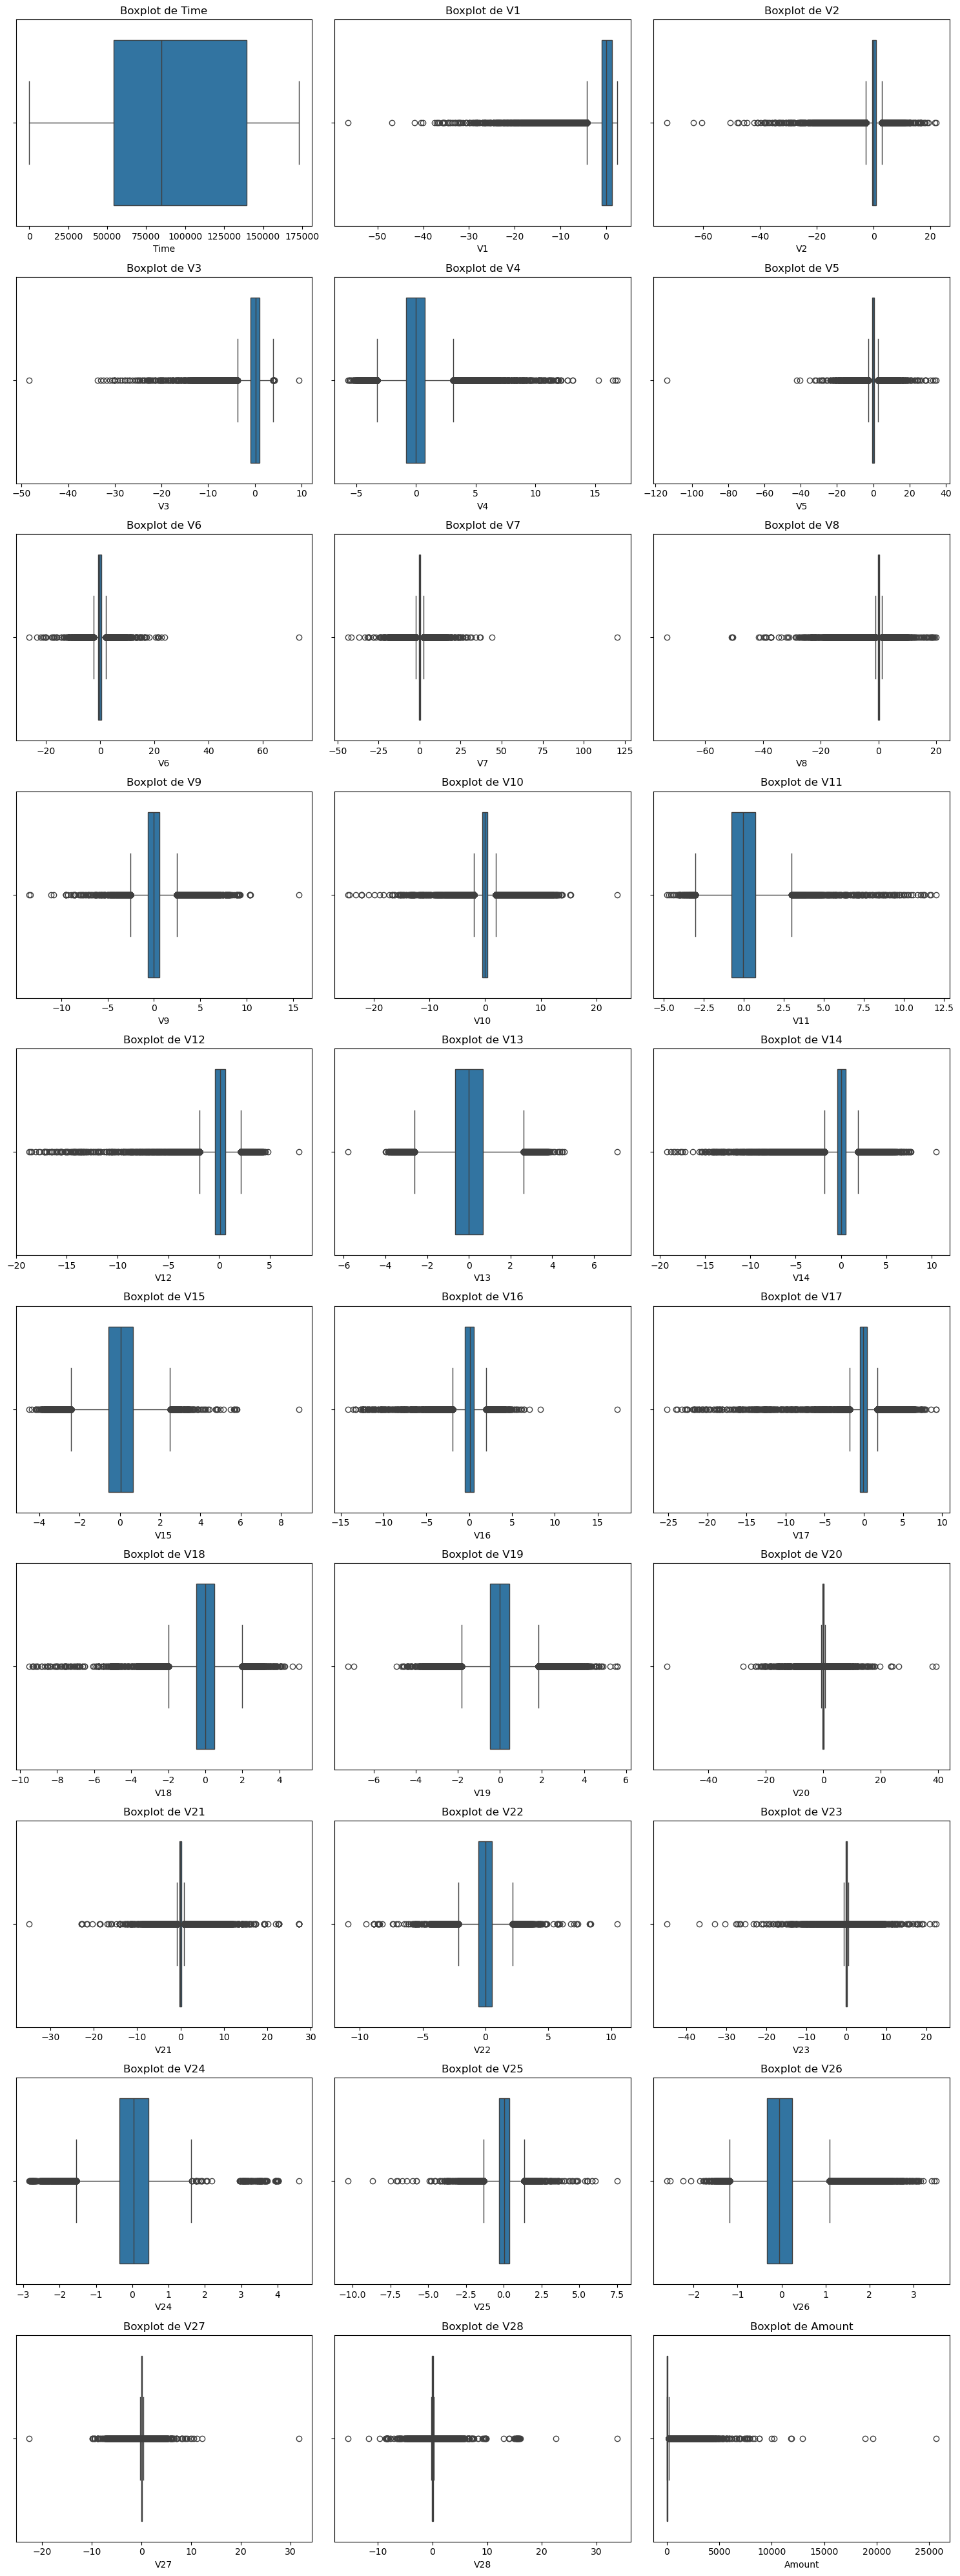

In [59]:
# Boxplot des variables
vars_to_plot = df.columns[:-1]
n_vars = len(vars_to_plot)
ncols = 3
nrows = int(np.ceil(n_vars / ncols))

plt.figure(figsize=(5 * ncols, 4 * nrows))
for i, column in enumerate(vars_to_plot):
    plt.subplot(nrows, ncols, i+1)
    sns.boxplot(x=df[column])
    plt.title(f"Boxplot de {column}")
plt.tight_layout()
plt.show()

- Nous constatons ici que pratiquement toutes les variables ont des distributions plutot normales, a l'exception de la variable "Amount" qui est fortement asymetrique a droite. 
- Nous constatons egalement la presence de beaucoup de valeurs aberrantes
- Les variables V1 à V28 ont une asymétrie beaucoup plus faible car elles sont issues d'une PCA (Analyse en Composantes Principales), une méthode qui tend naturellement à décorréler et à recentrer les données.

Tableau des asymétries (trié du plus asymétrique au moins asymétrique) :
         Skewness
Amount  16.977724
V28     11.192091
V21      3.592991
V7       2.553907
V6       1.826581
V10      1.187141
V4       0.676292
V26      0.576693
V9       0.554680
V11      0.356506
V19      0.109192
V13      0.065233
Time    -0.035568
V22     -0.213258
V18     -0.259880
V15     -0.308423
V25     -0.415793
V24     -0.552499
V16     -1.100966
V27     -1.170209
V14     -1.995176
V20     -2.037155
V3      -2.240155
V12     -2.278401
V5      -2.425901
V1      -3.280667
V17     -3.844914
V2      -4.624866
V23     -5.875140
V8      -8.521944


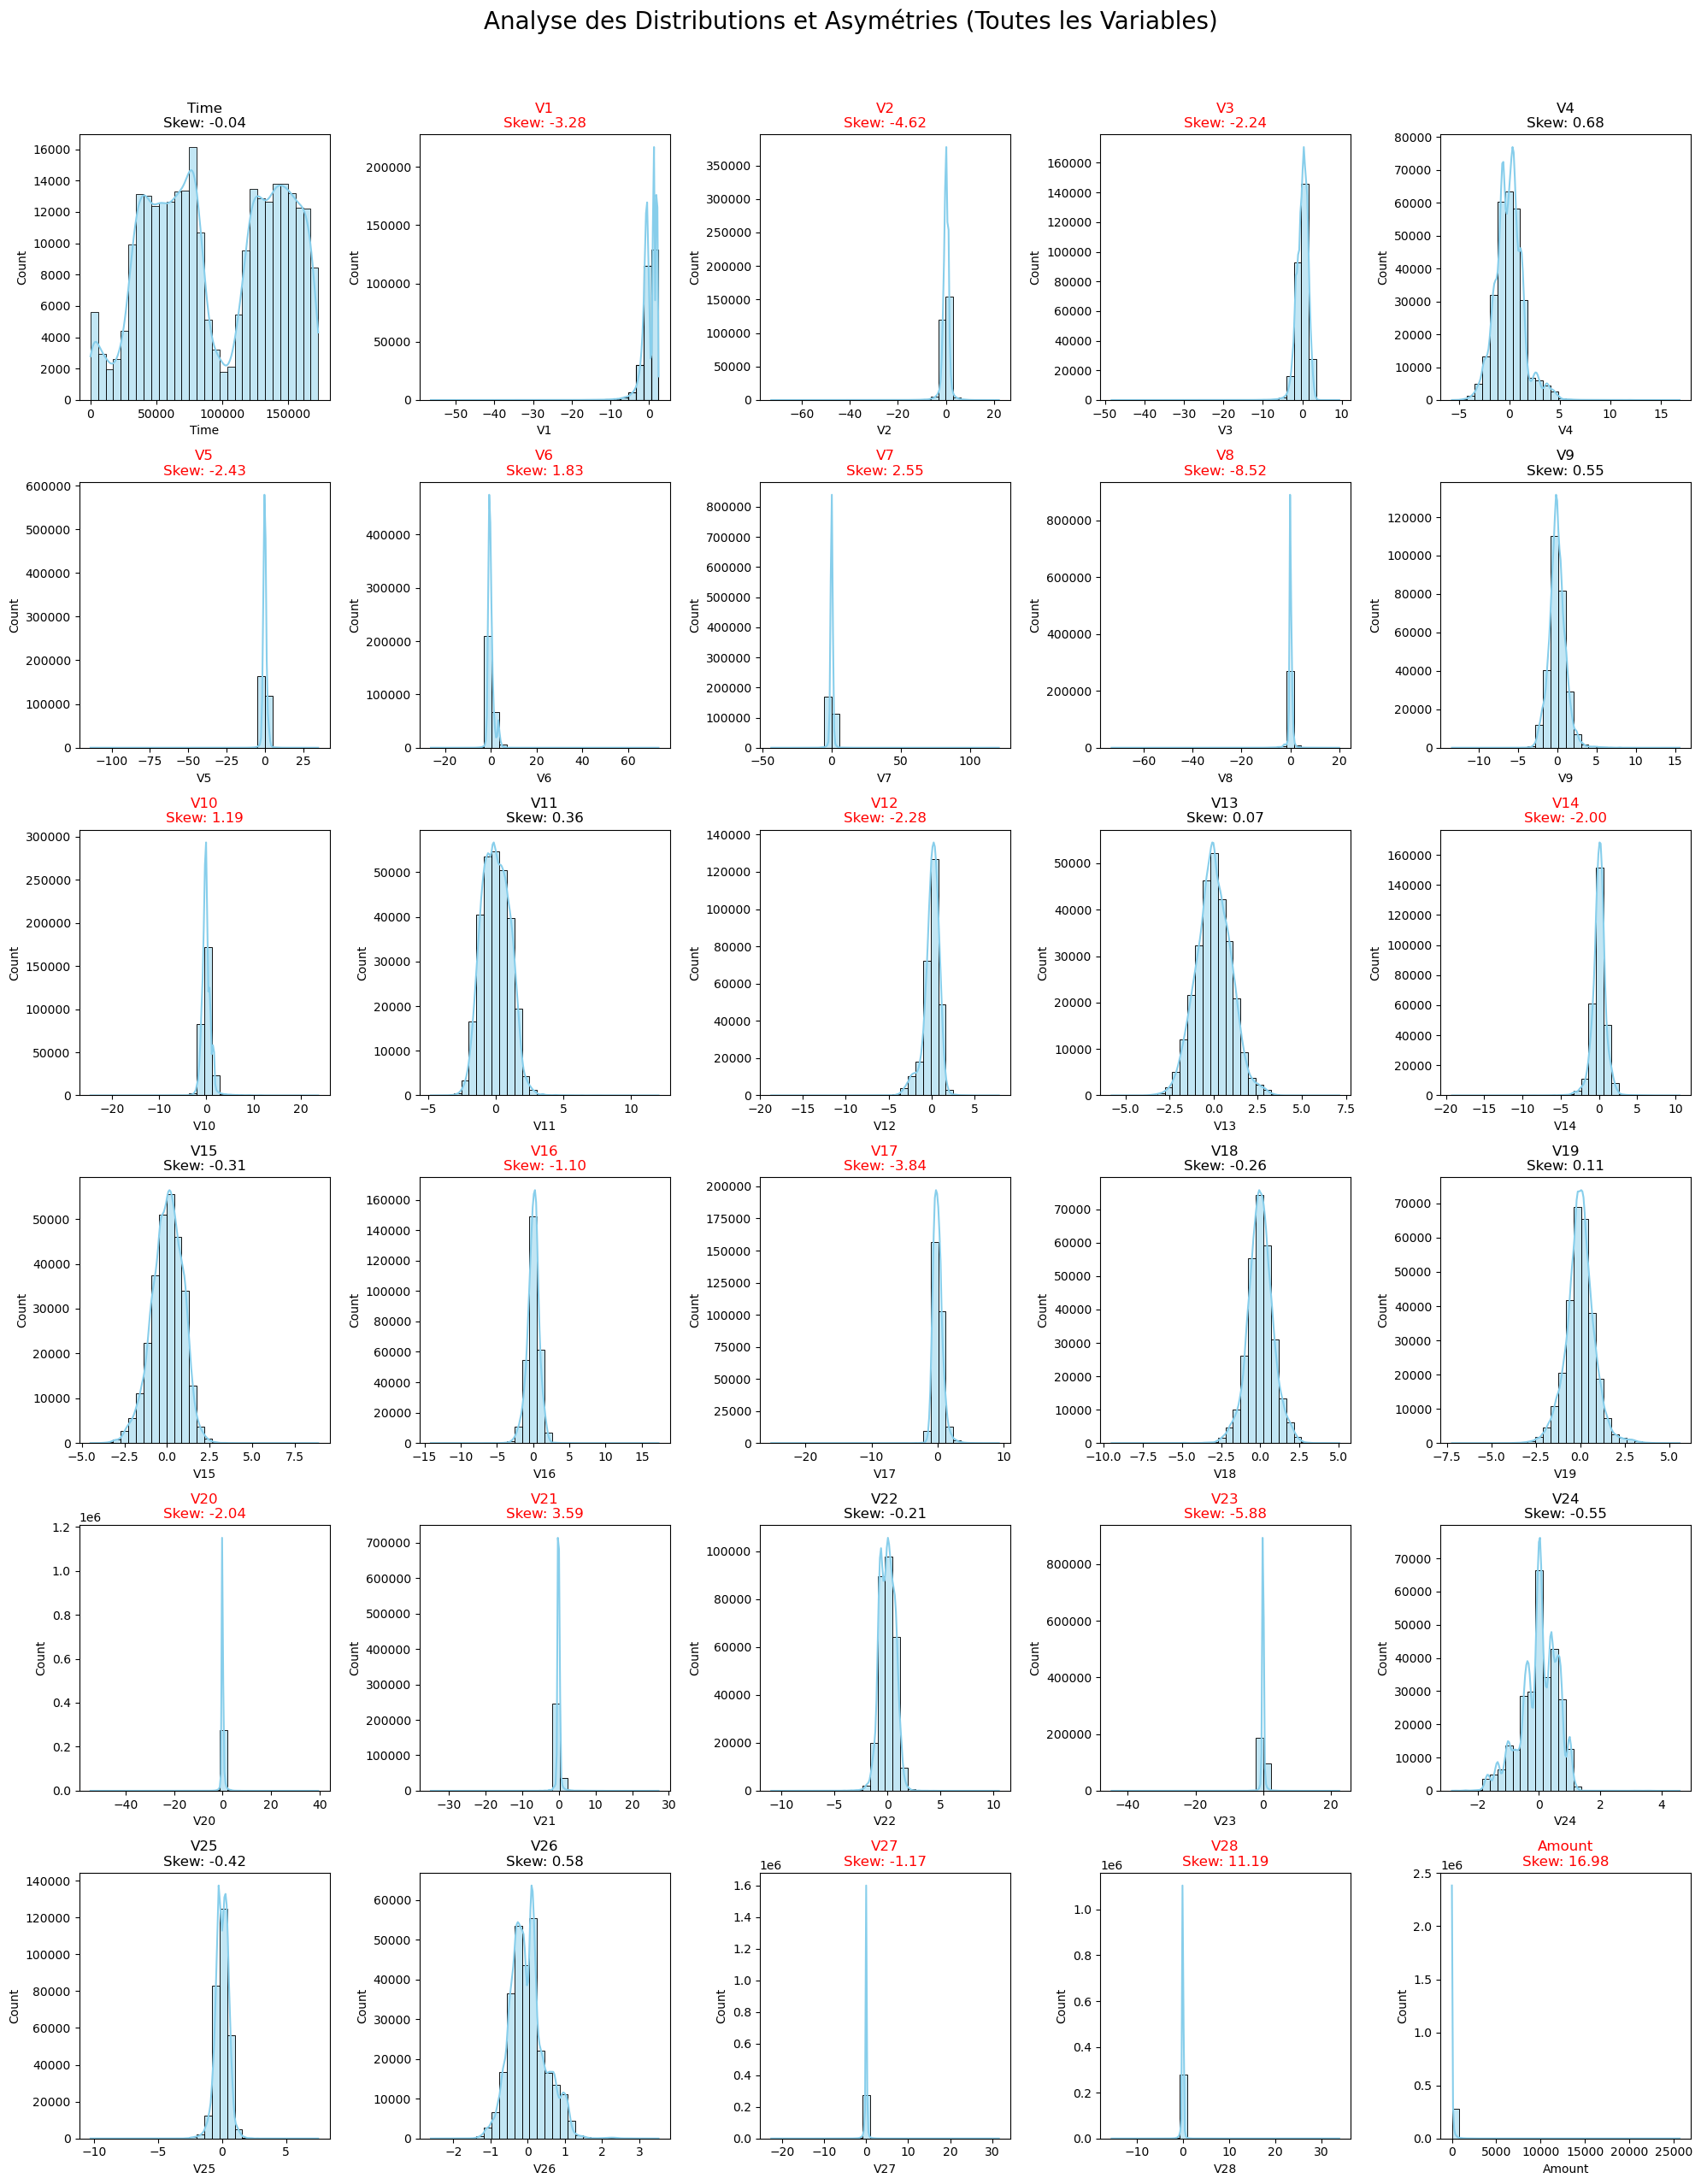

In [60]:

# 1. Calcul du coefficient d'asymétrie pour toutes les colonnes (sauf la cible 'Class')
all_features = df.drop('Class', axis=1)
skewness_df = all_features.skew().sort_values(ascending=False).to_frame(name='Skewness')

print("Tableau des asymétries (trié du plus asymétrique au moins asymétrique) :")
print(skewness_df)

# 2. Visualisation globale avec une grille de Histogrammes
# On crée une figure large pour accueillir les 30 variables (V1-V28, Time, Amount)
plt.figure(figsize=(20, 25))
plt.suptitle('Analyse des Distributions et Asymétries (Toutes les Variables)', fontsize=20, y=1.02)

for i, col in enumerate(all_features.columns):
    plt.subplot(6, 5, i + 1) # Grille de 6 lignes et 5 colonnes
    sns.histplot(df[col], kde=True, color='skyblue', bins=30)
    
    # Ajout du texte de la valeur de skewness sur chaque graphique
    skew_val = df[col].skew()
    plt.title(f'{col}\nSkew: {skew_val:.2f}', fontsize=12)
    
    # Coloration du titre en rouge si l'asymétrie est forte (|skew| > 1)
    if abs(skew_val) > 1:
        plt.gca().title.set_color('red')
        
    plt.tight_layout()

plt.show()

<Figure size 2000x1000 with 0 Axes>

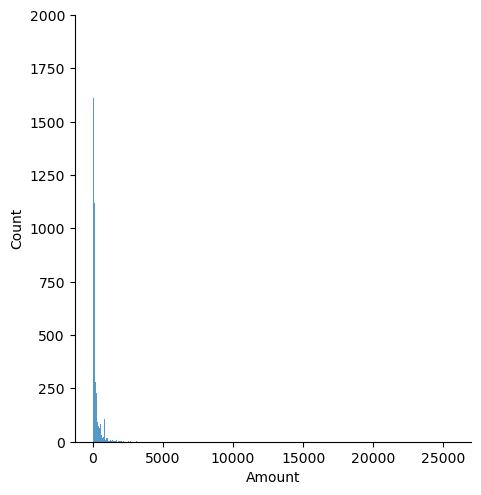

In [61]:
# Visualisation de la variable "Amount"
plt.figure(figsize=(10, 5), dpi=200)
sns.displot(data=df, x='Amount')
plt.ylim(0, 2000)
plt.show()

Comme constate plus haut, la variable "Amount" présente un coefficient d'asymétrie extrêmement élevé. Cela indique une distribution "étalée à droite", où une poignée de transactions ont des montants très importants par rapport à la masse.

Text(0.5, 1.0, 'Répartition des classes (0: Normal, 1: Fraude)')

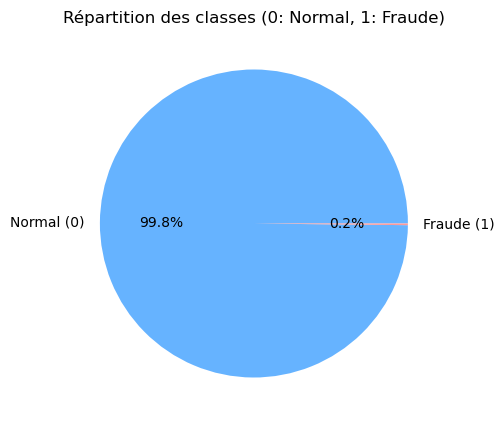

In [62]:
# Visualisation du déséquilibre de classes [cite: 31]
plt.figure(figsize=(8, 5))
plt.pie(df['Class'].value_counts(), labels=['Normal (0)', 'Fraude (1)'], autopct='%1.1f%%', colors=['#66b3ff','#ff9999'])
plt.title('Répartition des classes (0: Normal, 1: Fraude)')

### La classe 1 représente moins de 0.2% des transactions.

Nous constatons que la variable cible est fortement desequilibree. les transactions frauduleuses sont infiniment petites. Ce déséquilibre rend l’accuracy inadaptée comme métrique principale et nécessite l’utilisation de métriques spécifiques ainsi que de méthodes de rééquilibrage lors de l’apprentissage.

## Gestion des valeurs abérantes

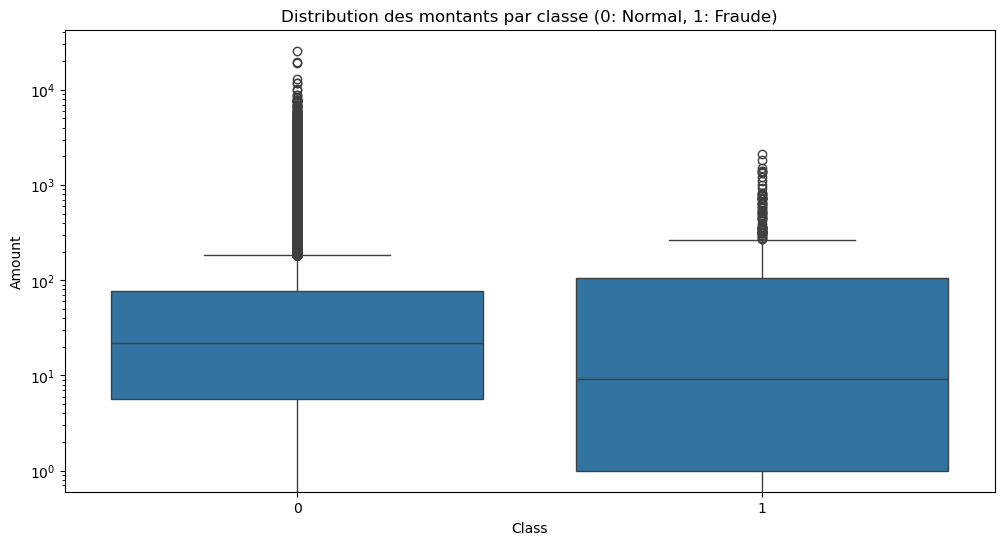

In [39]:
# Analyse visuelle des valeurs aberrantes (Outliers)
plt.figure(figsize=(12, 6))

# Boxplot pour le montant des transactions
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Distribution des montants par classe (0: Normal, 1: Fraude)')
plt.yscale('log') # Échelle log pour mieux voir malgré les extrêmes
plt.show()


#### Nous observons des valeurs extrêmes surtout dans les transactions normales, mais au lieu de les supprimer, nous appliquerons une transformation logarithmique sur la variable "Amount" et un RobustScaler sur la variable "Time" pour minimiser leur impact sur le modèle, car dans un contexte bancaire, les montants extremes peuvent eux aussi etre des signes de fraude.


## Identification des défis liés aux données


L'analyse diagnostique du jeu de données Credit Card Fraud Detection a permis d'identifier quatre défis majeurs qui influenceront la conception de notre pipeline de préparation:

**1. Déséquilibre extrême des classes** 

**Constat :** Le jeu de données est "fortement déséquilibré". Les transactions frauduleuses ne représentent qu'une infime fraction (environ 0,17 %) du total des 284 000 lignes.


**Défi :** Un modèle standard risque d'apprendre uniquement à prédire la classe majoritaire (transactions normales) pour obtenir une précision élevée, tout en ignorant totalement les fraudes, ce qui rendrait le modèle inutile en production.

**2. Hétérogénéité des échelles et asymétrie (Skewness)**

**Constat :** Alors que les variables V1 à V28 sont déjà centrées et réduites (issues d'une PCA), les variables Time et Amount possèdent des échelles et des distributions totalement différentes.

**Défi :** La variable Amount présente une forte asymétrie positive (quelques montants très élevés). Sans transformation, ces valeurs extrêmes risquent de saturer le modèle et de fausser l'apprentissage des frontières de décision.

**3. Anonymisation et limite de l'interprétation métier**

**Constat :** Pour des raisons de confidentialité, les caractéristiques d'origine ont été transformées en composantes PCA (V1-V28).

**Défi :** Nous ne connaissons pas la nature réelle de ces variables (ex: lieu, type de commerce, profil client). Cela limite notre capacité à créer de nouvelles variables ("Feature Engineering") basées purement sur une intuition métier.

**4. Tromperie des métriques d'évaluation classiques**

**Constat :** Dans un contexte de fraude, l'exactitude (Accuracy) n'est pas une mesure de performance fiable.

**Défi :** Si nous prédisons "0" (non-fraude) pour toutes les transactions, nous aurions 99,8 % de précision, mais nous raterions 100 % des fraudes. Le défi est de sélectionner des métriques adaptées comme le Recall, le F1-Score ou l'AUPRC pour valider le modèle.

# III. Préparation et transformations des variables

In [63]:
# Transformation 1 : Mise à l'échelle de "Time"
# Justification : Les modèles de ML sont sensibles à l'échelle des données. "Time" a une 
# plage de valeurs très large par rapport aux variables V1-V28.

df['scaled_time'] = RobustScaler().fit_transform(df['Time'].values.reshape(-1,1))

In [68]:
# Transformation 2 : Transformation logarithmique de "Amount"
# Justification : La distribution de "Amount" est très asymétrique (skewed). Le log réduit l'impact des valeurs extrêmes.

df['log_amount'] = np.log1p(df['Amount'])

In [65]:
# Affichons le dataset pour confirmer que les transformations ont bel et bien ete effectuees
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_time,log_amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,-0.994983,5.014760
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,-0.994983,1.305626
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,-0.994972,5.939276
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,-0.994972,4.824306
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,-0.994960,4.262539


In [66]:
df[["scaled_time", "log_amount"]]

,scaled_time,log_amount
0,-0.994983,5.014760
1,-0.994983,1.305626
2,-0.994972,5.939276
3,-0.994972,4.824306
4,-0.994960,4.262539
...,...,...
284802,1.034951,0.570980
284803,1.034963,3.249987
284804,1.034975,4.232366
284805,1.034975,2.397895


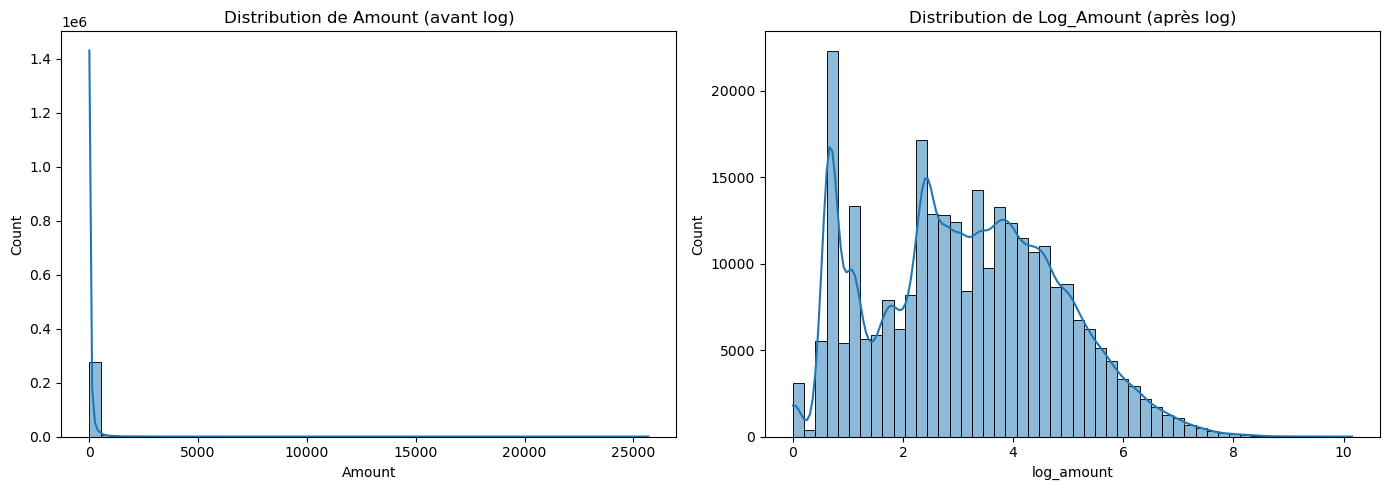

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Avant transformation
sns.histplot(df["Amount"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Distribution de Amount (avant log)")

# Après transformation
sns.histplot(df["log_amount"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Distribution de Log_Amount (après log)")

plt.tight_layout()
plt.show()

Nous constatons ici que l'application du Log sur la variable "Amount" a permis de rendre sa distribution beaucoup plus normale qu'avant, ceci en reduisant son asymetrie.

## IV. Création de nouvelles variables

In [77]:
# Variable 1 : Heure de la journée
# Justification : La fraude suit souvent des cycles temporels (ex: plus de fraudes la nuit). Donc cette variable pourra aider le modele a mieux capturer ces patterns temporels.

df['Hour'] = ( df['Time'] // 3600 ) % 24

In [72]:
# Variable 2 : Écart de montant par rapport à la moyenne
# Justification : Une transaction avec un montant inhabituellement élevé par rapport à la moyenne est statistiquement plus suspecte. cette variable pourra aider le modele a savoir si une transaction est anormalement élevée ou non, ce qui est un indicateur clé de fraude.

df['amount_vs_mean'] = df['log_amount'] - df['log_amount'].mean()

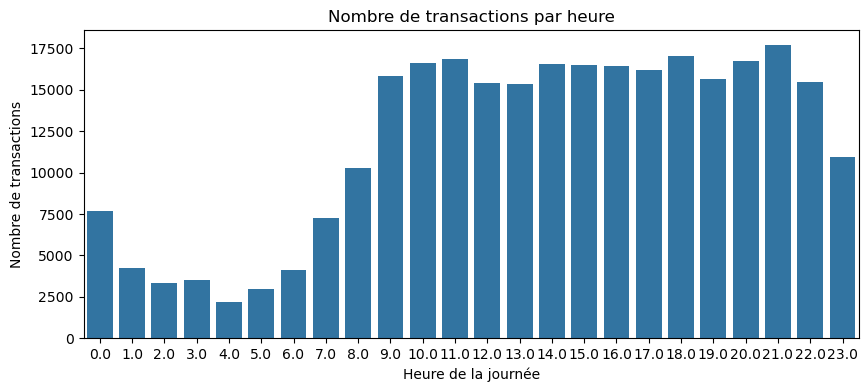

In [78]:
# Distribution de la variable "hour"
plt.figure(figsize=(10,4), dpi=100)
sns.countplot(x="Hour", data=df)
plt.title("Nombre de transactions par heure")
plt.xlabel("Heure de la journée")
plt.ylabel("Nombre de transactions")
plt.show()

Nous constatons une grande concentration de transaction dans la plage d'heures allant de 8h a 22h et le contraire le reste du temps. En effet, cette information nous permet de savoir exactemet a quel moment de la journee s'effectue les grosses transactions, et donc plus de signaux de fraudes possibles.

In [81]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V25,V26,V27,V28,Amount,Class,scaled_time,log_amount,amount_vs_mean,Hour
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.128539,-0.189115,0.133558,-0.021053,149.62,0,-0.994983,5.014760,1.862572,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.167170,0.125895,-0.008983,0.014724,2.69,0,-0.994983,1.305626,-1.846562,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,-0.994972,5.939276,2.787088,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.647376,-0.221929,0.062723,0.061458,123.50,0,-0.994972,4.824306,1.672118,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.206010,0.502292,0.219422,0.215153,69.99,0,-0.994960,4.262539,1.110351,0.0


## V. Gestion du déséquilibre de classes

In [85]:
# suppression des colonnes "Time" et "Amount" qui ont été transformées
df.drop(['Time', 'Amount'], axis=1, inplace=True)

In [86]:
# =================================================================
# 1. PRÉPARATION : Division Train/Test (Essentiel pour éviter le leakage)
# =================================================================
# On sépare avant toute manipulation de rééchantillonnage
X = df.drop('Class', axis=1)
y = df['Class']

# Stratify=y permet de conserver la proportion de fraude dans les deux jeux
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [83]:
# ---------------------------------------------------------
# APPLICATION DES MÉTHODES 
# ---------------------------------------------------------

# Méthode 1 : Under-sampling sur le TRAIN uniquement
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

# Méthode 2 : SMOTE sur le TRAIN uniquement
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Fraudes après SMOTE (Train) : {y_train_smote.sum()}")
print(f"Fraudes dans le set de Test (Intouché) : {y_test.sum()}")

Fraudes après SMOTE (Train) : 227451
Fraudes dans le set de Test (Intouché) : 98


--- APPLICATION DE L'UNDER-SAMPLING ---
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56864
           1       0.04      0.92      0.07        98

    accuracy                           0.96     56962
   macro avg       0.52      0.94      0.53     56962
weighted avg       1.00      0.96      0.98     56962

AUPRC (Under-sampling): 0.6309


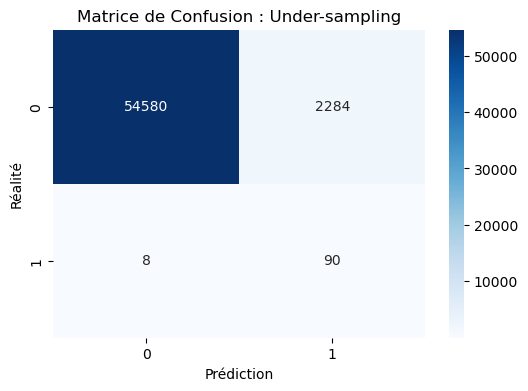

In [87]:
# =================================================================
# 2. MÉTHODE 1 : UNDER-SAMPLING (SOUS-ÉCHANTILLONNAGE)
# =================================================================
print("--- APPLICATION DE L'UNDER-SAMPLING ---")

# Application sur le jeu d'entraînement uniquement
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

# Entraînement du modèle
model_rus = LogisticRegression(max_iter=1000)
model_rus.fit(X_train_rus, y_train_rus)

# Prédictions et Probabilités
y_pred_rus = model_rus.predict(X_test)
y_prob_rus = model_rus.predict_proba(X_test)[:, 1]

# Métriques
print(classification_report(y_test, y_pred_rus))
auprc_rus = average_precision_score(y_test, y_prob_rus)
print(f"AUPRC (Under-sampling): {auprc_rus:.4f}")

# Visualisation : Matrice de Confusion 1
plt.figure(figsize=(6, 4))
cm_rus = confusion_matrix(y_test, y_pred_rus)
sns.heatmap(cm_rus, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion : Under-sampling')
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.show()

- Le modele Under Sampling affiche un recall de 92% pour les transaction frauduleuses, ce qui est un resultat correct pour la dectection des fraudes (Sur 100 fraudes qui tentent de passer, seulement 8 ne sont pas detectees). 
- Neanmoins il affiche une precision de 4% qui est extremement basse. Ceci signifie que lorsqu'il y a une alerte de fraude, le modele n'a raison que dans 4% des cas.
- AUPRC = 63%, ce qui est correcte, mais ameliorable
- Dans un contexte bancaire, cela implique de bloquer inutilement des cartes de nombreux clients honnetes, ce qui n'est pas bon pour la banque et ses clients.

En conclusion, l'Under-sampling a permis au modèle de bien "apprendre" ce qu'est une fraude en lui donnant autant d'exemples de fraudes que de transactions normales. Cependant, en supprimant massivement des transactions normales pour l'entraînement, le modèle a perdu la capacité de distinguer finement les transactions légitimes complexes, d'où le taux élevé de fausses alertes.




--- APPLICATION DU SMOTE ---
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.05      0.92      0.10        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.54     56962
weighted avg       1.00      0.97      0.98     56962

AUPRC (SMOTE): 0.7258


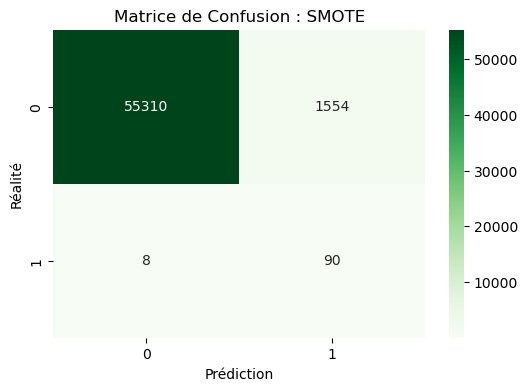

In [88]:
# =================================================================
# 3. MÉTHODE 2 : SMOTE (SUR-ÉCHANTILLONNAGE SYNTHÉTIQUE)
# =================================================================
print("\n--- APPLICATION DU SMOTE ---")

# Application sur le jeu d'entraînement uniquement
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Entraînement du modèle
model_smote = LogisticRegression(max_iter=1000)
model_smote.fit(X_train_smote, y_train_smote)

# Prédictions et Probabilités
y_pred_smote = model_smote.predict(X_test)
y_prob_smote = model_smote.predict_proba(X_test)[:, 1]

# Métriques
print(classification_report(y_test, y_pred_smote))
auprc_smote = average_precision_score(y_test, y_prob_smote)
print(f"AUPRC (SMOTE): {auprc_smote:.4f}")

# Visualisation : Matrice de Confusion 2
plt.figure(figsize=(6, 4))
cm_smote = confusion_matrix(y_test, y_pred_smote)
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Greens')
plt.title('Matrice de Confusion : SMOTE')
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.show()

- Le modele SMOTE affiche un recall de 92% lui aussi pour les transaction frauduleuses, ce qui est un resultat correct pour la dectection des fraudes. 
- Neanmoins il affiche une precision de 5% qui est extremement basse elle aussi, mais legerement meilleure que l'Under Sampling. 
- Son f1-score est de 0,10 au lieu de 0,7 chez l'Under Sampling.
- AUPRC = 72%, ce qui est correcte et mieux que chez l'Under Sampling.




## **Conclusion:**
Malgre sa precision faible, le SMOTE s'avère supérieur car il ne supprime aucune donnée du jeu majoritaire. En conservant les 284 000 transactions normales , le modèle apprend une frontière de décision beaucoup plus précise que l'Under-sampling, qui perdait trop d'informations sur la nature des transactions légitimes

## VI. Validation de Jeu de données final

In [89]:
def validate_final_dataset(X_train_res, y_train_res, X_test, y_test):
    print("--- RAPPORT DE VALIDATION FINALE ---")
    
    # 1. Vérification des dimensions
    print(f"Dimensions Train (Features): {X_train_res.shape}")
    print(f"Dimensions Train (Cible): {y_train_res.shape}")
    print(f"Dimensions Test (Features): {X_test.shape}")
    
    # 2. Vérification de l'absence de valeurs manquantes (NaN)
    nan_count = pd.DataFrame(X_train_res).isnull().sum().sum()
    print(f"\nNombre de valeurs manquantes dans le set d'entraînement : {nan_count}")
    
    # 3. Vérification de l'équilibre des classes final
    # On compare le set d'entraînement (équilibré) et le set de test (réaliste)
    train_balance = pd.Series(y_train_res).value_counts(normalize=True) * 100
    test_balance = pd.Series(y_test).value_counts(normalize=True) * 100
    
    print("\nÉquilibre des classes (en %) :")
    print(f"Entraînement : \n{train_balance}")
    print(f"Test (Réalité) : \n{test_balance}")
    
    # 4. Aperçu des types de données
    print("\nTypes de données des colonnes finales :")
    print(X_train_res.dtypes.value_counts())

# Exécution de la validation pour le dataset traité par SMOTE (généralement le meilleur)
validate_final_dataset(X_train_smote, y_train_smote, X_test, y_test)



--- RAPPORT DE VALIDATION FINALE ---
Dimensions Train (Features): (454902, 32)
Dimensions Train (Cible): (454902,)
Dimensions Test (Features): (56962, 32)

Nombre de valeurs manquantes dans le set d'entraînement : 0

Équilibre des classes (en %) :
Entraînement : 
Class
0    50.0
1    50.0
Name: proportion, dtype: float64
Test (Réalité) : 
Class
0    99.827955
1     0.172045
Name: proportion, dtype: float64

Types de données des colonnes finales :
float64    32
Name: count, dtype: int64
